# Goal & Setup

The purpose of this code is to apply several tests from Bastos and O'Hagan (2009) to determine the quality of our RCP emulator, to see if it concurs with the ISM simulations. An adapation of their primary test is a Leave-One-Out analysis (LOO) to assess how well the **fit//trained** emulator reproduces the simulated runs.

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [2]:
# define the colormap
plt.set_cmap('viridis')
# define the save path for our plots
save_path='./figures/'
# define 14 different colors for the timeseries plots
from lig_utilities import call_scm_cmap, uniform_cmap_slices
cmap=call_scm_cmap('roma')
cols=uniform_cmap_slices(cmap,14,col_range=[0,1.0])[::-1]
# define the BuRd colormap
cmap_RdBu = plt.cm.get_cmap('RdBu')
# import the rectangle feature
import matplotlib.patches as patches
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package to load the GP model and sample
import gpflow
from lig_utilities import normalize, denormalize
# load the modules to compute the statistics
from lig_utilities import posterior_densities_rcp85, find_quantile_i, find_quantile_ts
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Data & Model

## Load the Emulator

### Load the Training Data (to reconstruct the GP model)

In [4]:
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( "./models/rcp_model_traindata.pk1", "rb" ) )
train_dat.keys()

dict_keys(['clifvmax', 'model_name', 'Y_train', 'time', 'kernel_code', 'crevliq', 'X_train'])

### Restore the Trained GP model

In [5]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name=train_dat['model_name'])
    
    # Fix the nugget term
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
  
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, "./models/rcp_model.ckpt")
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


Model loaded from path: None


In [6]:
# print the hyperparameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
rcp_model/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.5012107704313864
rcp_model/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.830591620175421
rcp_model/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.4548666355127329
rcp_model/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,1.8310064734237486
rcp_model/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.7567453807220614
rcp_model/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,2731.897366783309
rcp_model/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


### Get Baseline Samples

Here we sample the model at the training data points, for a baseline prediction.

In [7]:
# get model outputs along grid
baseline_mean,baseline_var=m.predict_y(train_dat['X_train'])

In [8]:
baseline_mean_cc=baseline_mean.reshape(len(train_dat['time']),len(train_dat['crevliq']),len(train_dat['clifvmax']))
baseline_var_cc=baseline_var.reshape(len(train_dat['time']),len(train_dat['crevliq']),len(train_dat['clifvmax']))

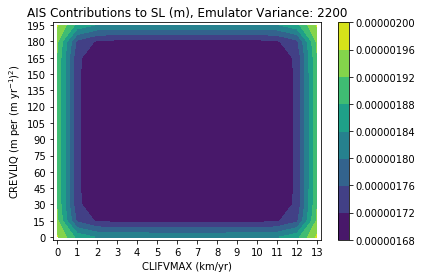

In [9]:
# plot the sample
gp_var_fig=plt.figure()
c1=plt.contourf(train_dat['clifvmax'],train_dat['crevliq'],baseline_var_cc[-1,:,:])
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('AIS Contributions to SL (m), Emulator Variance: 2200')
plt.colorbar(c1)
plt.show()

# LOO Samples

We do not have additional simulations on which our emulator was not trained (e.g. "holding-out" a portion of the data when doing the training step). Instead, we will do our sampling entirely on the training data grid, and will apply LOO methods to see how our predictions perform.

Let's loop through and grab the mean and variance values when one of the simulations is left out.

In [10]:
train_dat['Y_train'].shape

(22, 196)

In [11]:
# get the number of ensemble members
n_i=train_dat['Y_train'].shape[1]
ll_loo=[]
mean_loo=[]
var_loo=[]

# loop over all of the ensemble members to do the LOO analyses
for i in range(n_i):
    
    # find the indices to remove from our training data, removing
    # each timestep associated with the ensemble member
    loo_inds=np.arange(22)*196+i
    #print(loo_inds)
    
    # get the LOO conditioning/date arrays
    loo_rcp_train=np.delete(train_dat['Y_train'],0,axis=1)
    loo_X_train=np.delete(train_dat['X_train'], loo_inds, axis=0)
    
    # condition the trained emulator
    m_loo=gpflow.models.GPR(loo_X_train, loo_rcp_train.reshape(np.size(loo_rcp_train),1), kern=k)

    # sample from the emulator
    mean_out,var_out=m_loo.predict_y(train_dat['X_train'][loo_inds,:])
    
    # store the data from the sample:
    mean_loo.append(mean_out)
    var_loo.append(var_out)
    ll_loo.append(m_loo.compute_log_likelihood())
    
    # tell us where we are in the loop
    print(i)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


We will examine over specific times (2000, 2050, 2100, and 2150) for our LOO, and for each of these we will need to construct a grid with which we can do our LOO sampling. We start building that here, and will finalize its construction in loop when we perform the LOO analysis.

In [12]:
# reorganize the data
loo_mean,loo_var=np.squeeze(np.asarray(mean_loo,dtype='float')).T,np.squeeze(np.asarray(var_loo,dtype='float')).T

In [13]:
# sub-select the years we care about (2000, 2050, 2100, 2150), and transpose to share a shape with the training data
yearinds=[1,6,11,16]
subyears_mean,subyears_var=loo_mean[yearinds,:],loo_var[yearinds,:]

# Diagnostics

We apply some diagnostics (such as those commonly used, and presented in Bastos and O'Hagan, 2009), by taking the validation points and looking at the LOO emulated values and the actual simulated values at those locations.

### Standardized Prediction Error, $D_i^I$

This error is given at every location in the training simulation dataset, and if the emulator properly represents the simulator, then the errors should mimic a Student-t distribution, conditional on the training data and hyperparameters; with some errors for edge effects in the emulator training.

In [15]:
train_dat['Y_train'].shape

(22, 196)

In [16]:
# calculate the standardized prediction error for each year
diff=train_dat['Y_train'][yearinds,:]-subyears_mean
DiY=(train_dat['Y_train'][yearinds,:]-subyears_mean)/np.sqrt(subyears_var)

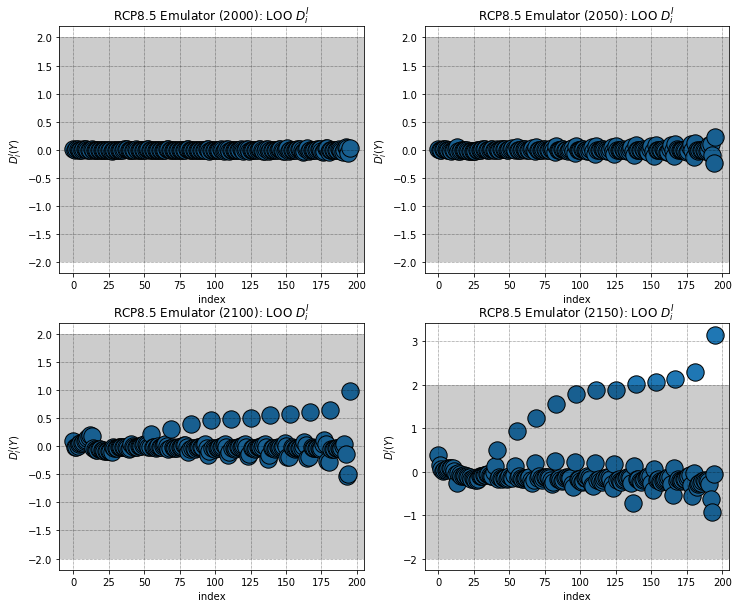

In [17]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.scatter(np.arange(196),DiY[0,:],s=300,edgecolors='k')
# shade the region between -2 and 2 (the 95% confidence intervals for a Student-t distribution)
plt.axhspan(-2, 2, facecolor='k', alpha=0.2)
plt.axis('tight')
plt.title('RCP8.5 Emulator (2000): LOO $D_i^I$')
plt.ylabel('$D_i^I(Y)$')
plt.xlabel('index')
plt.grid()

plt.subplot(2,2,2)
plt.scatter(np.arange(196),DiY[1,:],s=300,edgecolors='k')
# shade the region between -2 and 2 (the 95% confidence intervals for a Student-t distribution)
plt.axhspan(-2, 2, facecolor='k', alpha=0.2)
plt.axis('tight')
plt.title('RCP8.5 Emulator (2050): LOO $D_i^I$')
plt.ylabel('$D_i^I(Y)$')
plt.xlabel('index')
plt.grid()

plt.subplot(2,2,3)
plt.scatter(np.arange(196),DiY[2,:],s=300,edgecolors='k')
# shade the region between -2 and 2 (the 95% confidence intervals for a Student-t distribution)
plt.axhspan(-2, 2, facecolor='k', alpha=0.2)
plt.axis('tight')
plt.title('RCP8.5 Emulator (2100): LOO $D_i^I$')
plt.ylabel('$D_i^I(Y)$')
plt.xlabel('index')
plt.grid()

plt.subplot(2,2,4)
plt.scatter(np.arange(196),DiY[3,:],s=300,edgecolors='k')
# shade the region between -2 and 2 (the 95% confidence intervals for a Student-t distribution)
plt.axhspan(-2, 2, facecolor='k', alpha=0.2)
plt.axis('tight')
plt.title('RCP8.5 Emulator (2150): LOO $D_i^I$')
plt.ylabel('$D_i^I(Y)$')
plt.xlabel('index')
plt.grid()
plt.show()

In [18]:
print(np.sum(DiY[3,:]>2)/196)
print(2.5/100)

0.0255102040816
0.025


These errors are relatively small until 2150. Let's look at how they vary in CREVLIQ/CLIFVMAX space:

In [19]:
# create a meshgrid of the defined parameters to plot, and then reshape
xv, yv= np.meshgrid(train_dat['clifvmax'], train_dat['crevliq'], indexing='ij')
X=np.transpose([yv,xv]).reshape(196,2)

/opt/sw/packages/gcc-4.8/python/3.5.2/lib/python3.5/site-packages/numpy-1.11.3-py3.5-linux-x86_64.egg/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


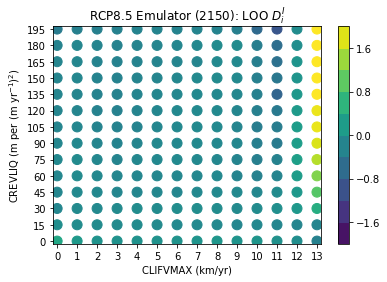

In [20]:
clevels=np.linspace(-2,2,11)
# build a plain background to fix our colorbar
miss=np.empty((14,14),dtype='float64')
miss[:]=np.nan
c1=plt.contourf(train_dat['clifvmax'],train_dat['crevliq'],miss,clevels)
c2=plt.scatter(X[:,1],X[:,0],c=np.squeeze(DiY[3,:]),s=100,norm=c1.norm)
plt.title('RCP8.5 Emulator (2150): LOO $D_i^I$')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.colorbar(c1)
plt.show()

We see that the edge effect above is important for driving errors for our given emulator structure, and affects the results mostly in the highest values of CLIFVMAX. Still errors remain largely below the unacceptable level, and overall errors are within what is expected for a properly trained emulator.

### Normalized Euclidean Distance, $d$

Following the procedure of Edwards et al. (2019), for comparison, we may explore the LOO on our emulator by looking at these standardized prediction errors and their sum:

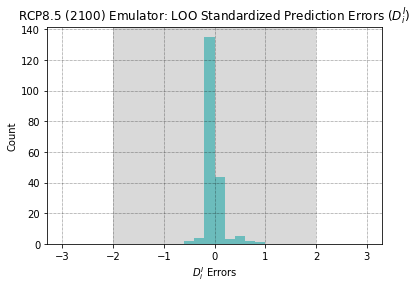

In [21]:
rcp2100_diy_hist=plt.figure()
plt.grid()
plt.hist(DiY[2,:],bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.title('RCP8.5 (2100) Emulator: LOO Standardized Prediction Errors ($D_i^I$)')
plt.xlabel('$D_i^I$ Errors')
plt.ylabel('Count')
plt.show()

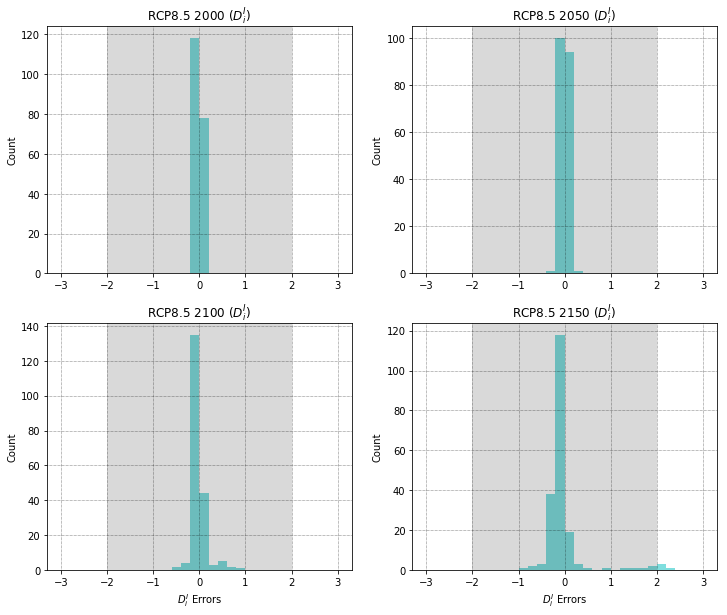

In [22]:
rcpalltimes_diy_hist=plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.grid()
plt.hist(DiY[0,:],bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.ylabel('Count')
plt.title('RCP8.5 2000 ($D_i^I$)')

plt.subplot(2,2,2)
plt.grid()
plt.hist(DiY[1,:],bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.ylabel('Count')
plt.title('RCP8.5 2050 ($D_i^I$)')

plt.subplot(2,2,3)
plt.grid()
plt.hist(DiY[2,:],bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.xlabel('$D_i^I$ Errors')
plt.ylabel('Count')
plt.title('RCP8.5 2100 ($D_i^I$)')

plt.subplot(2,2,4)
plt.grid()
plt.hist(DiY[3,:],bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.xlabel('$D_i^I$ Errors')
plt.ylabel('Count')
plt.title('RCP8.5 2150 ($D_i^I$)')

plt.show()

In [23]:
# save the plot out
save_path='./figures/'
savename='FigS4.pdf'
rcpalltimes_diy_hist.savefig(save_path+savename)

In [24]:
d_2000=np.sqrt(np.sum(np.power(train_dat['Y_train'][yearinds[0],:]-subyears_mean[0,:],2)/subyears_var[0,:]))
d_2050=np.sqrt(np.sum(np.power(train_dat['Y_train'][yearinds[1],:]-subyears_mean[1,:],2)/subyears_var[1,:]))
d_2100=np.sqrt(np.sum(np.power(train_dat['Y_train'][yearinds[2],:]-subyears_mean[2,:],2)/subyears_var[2,:]))
d_2150=np.sqrt(np.sum(np.power(train_dat['Y_train'][yearinds[3],:]-subyears_mean[3,:],2)/subyears_var[3,:]))
print('2000: '+str(d_2000))
print('2050: '+str(d_2050))
print('2100: '+str(d_2100))
print('2150: '+str(d_2150))

2000: 0.186217507733
2050: 0.566298584031
2100: 2.19935912328
2150: 7.15670629001
